In [1]:
%matplotlib inline


# Abinitio Pipeline - Simulated Data

This notebook introduces a selection of
components corresponding to generating realistic
simulated Cryo-EM data and running key ASPIRE-Python
Abinitio model components as a pipeline.


## Imports
First import some of the usual suspects.
In addition, import some classes from
the ASPIRE package that will be used throughout this experiment.



In [9]:
import logging

import numpy as np
from scipy.spatial.transform import Rotation as sp_rot

import torch

from aspire.basis import FSPCABasis, FFBBasis2D, FFBBasis3D
from aspire.source import Simulation
from aspire.volume import Volume

logger = logging.getLogger(__name__)

## Parameters
Some example simulation configurations.
Small sim: img_size 32, num_imgs 10000, n_classes 1000, n_nbor 10
Medium sim: img_size 64, num_imgs 20000, n_classes 2000, n_nbor 10
Large sim: img_size 129, num_imgs 30000, n_classes 2000, n_nbor 20



In [10]:
sim = "small"

if sim == "small":
    interactive = True  # Draw blocking interactive plots?
    do_cov2d = False  # Use CWF coefficients
    img_size = 32  # Downsample the volume to a desired resolution
    num_imgs = 10000  # How many images in our source.
    n_classes = 1000  # How many class averages to compute.
    n_nbor = 10  # How many neighbors to stack
    noise_variance = 5e-7  # Set a target noise variance

if sim == "medium":
    interactive = True  # Draw blocking interactive plots?
    do_cov2d = False  # Use CWF coefficients
    img_size = 64  # Downsample the volume to a desired resolution
    num_imgs = 20000  # How many images in our source.
    n_classes = 2000  # How many class averages to compute.
    n_nbor = 10  # How many neighbors to stack
    noise_variance = 5e-5  # Set a target noise variance

if sim == "large":
    interactive = True  # Draw blocking interactive plots?
    do_cov2d = False  # Use CWF coefficients
    img_size = 129  # Downsample the volume to a desired resolution
    num_imgs = 30000  # How many images in our source.
    n_classes = 2000  # How many class averages to compute.
    n_nbor = 20  # How many neighbors to stack
    noise_variance = 5e-7  # Set a target noise variance

## Simulation Data
Start with a fairly hi-res volume available from EMPIAR/EMDB.
https://www.ebi.ac.uk/emdb/EMD-2660
https://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-2660/map/emd_2660.map.gz



In [14]:
og_v = Volume.load("map-data/emd_2660.map.gz", dtype=np.float64)

logger.info(f"Downsampling to {(img_size,)*3}")
v = og_v.downsample(img_size)
L = v.resolution


# Then create a filter based on that variance
# This is an example of a custom noise profile

# Finally create the Simulation
src = Simulation(
    L=v.resolution,
    n=num_imgs,
    vols=v,
    dtype=v.dtype,
)

src = Simulation()


2023-03-06 17:32:11,201 INFO [aspire.volume.volume] map-data/emd_2660.map.gz with dtype float32 loaded as <class 'numpy.float64'>
2023-03-06 17:32:11,365 INFO [__main__] Downsampling to (32, 32, 32)
2023-03-06 17:32:13,580 INFO [aspire.source.image] Creating Simulation with 10000 images.
2023-03-06 17:32:13,621 INFO [aspire.source.image] Creating Simulation with 1024 images.


In [17]:
# get rot vecs for each
# normalize
# get fspca from projections
# train templates

basis = FSPCABasis(src=src, components=10, batch_size=512)


2023-03-06 17:32:35,257 INFO [aspire.basis.ffb_2d] Expanding 2D image in a frequency-domain Fourier–Bessel basis using the fast method.
2023-03-06 17:32:35,268 INFO [aspire.basis.fspca] Estimating the noise of images.
2023-03-06 17:32:35,271 INFO [aspire.noise.noise] Determining Noise variance in batches of 512


100%|██████████| 2/2 [00:00<00:00, 14.24it/s]

2023-03-06 17:32:35,416 INFO [aspire.noise.noise] Noise variance = 0.0012023244015967637
2023-03-06 17:32:35,418 INFO [aspire.basis.fspca] Setting noise_var=0.0012023244053125381
2023-03-06 17:32:35,421 INFO [aspire.covariance.covar2d] CTF filters are not included in Cov2D denoising


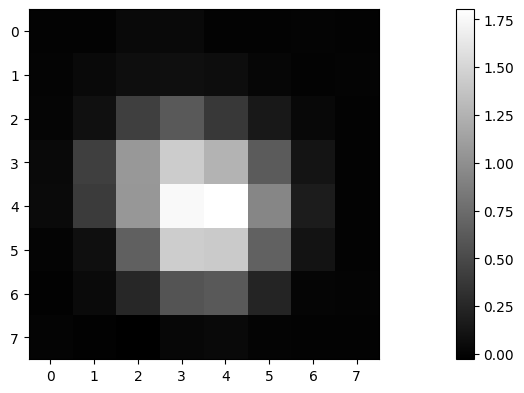

In [19]:
src.images[0].show()

In [18]:
basis.cov2d.basis.evaluate_t(src.images[0])

RuntimeError: The data has an uncaught error that led to the planner returning NULL. This is a bug.

In [ ]:
sp_rotations = sp_rot.from_matrix(src.rotations)
rot_vecs = sp_rotations.as_rotvec()
rot_vecs /= np.linalg.norm(rot_vecs, axis=-1)[:,np.newaxis]
rot_vecs = torch.from_numpy(rot_vecs)
rot_vecs = torch.stack((rot_vecs,rot_vecs), dim=1).view(2*rot_vecs.shape[0],rot_vecs.shape[1])


coefs = basis.spca_coef
coefs = basis.to_complex(coefs)
coefs = torch.from_numpy(coefs)

In [ ]:
rotvecs_inners = rot_vecs @ rot_vecs.T

: 

: 

In [ ]:
def process_coefs

In [58]:
num_templates = 40
lr = 0.1

indices = torch.randperm(len(coefs))[:num_templates]
coefs_copy = coefs.data.clone()
Z = coefs_copy[indices].requires_grad_(True)

optim = torch.optim.Adam([Z], lr = lr)

def max_filter_torch(Z, coefs, rot_vecs, basis, padding = 400):
    num_temp = Z.shape[0]
    num_pics = coefs.shape[0]
    matrix_result = torch.zeros(num_temp, num_pics*2)

    max_filter_bank = []
    max_filter_bank_refl = []

    for i in range(num_pics):
        output = basis.pca_basis.max_filter_bank(coefs[i], Z, basis.max_filter_fft, padding)
        reg_out = torch.from_numpy(output[0]).view(num_temp,1)
        refl_out = torch.from_numpy(output[1]).view(num_temp,1)
        matrix_result[:,2*i] = reg_out
        matrix_result[:,2*i+1] = refl_out

    return np.array(max_filter_bank), np.array(max_filter_bank_refl)


    basis.max_filter_bank(coefs, Z, basis.max_filter_fft, 400)



def max_filter_torch_on_hold(Z, coefs, rot_vecs, indices, padding = 400):
    num_temp = Z.shape[0]
    num_pics = coefs.shape[0]
    matrix_result = torch.zeros(num_temp, num_pics)
    for i in range(num_temp):
        for j in range(num_pics): 
            # get the max filter
            # add to result

def loss(Z, coefs, rot_vecs, basis):
    vecs = 0


In [ ]:
def max_filter_torch_legacy(Z, coefs, rotvecs_inners, basis, padding = 400):
    num_temp = Z.shape[0]
    num_pics = coefs.shape[0]
    matrix_result = torch.zeros(num_temp, num_pics*2)

    for i in range(num_pics):
        output = basis.max_filter_bank_fft(coefs[i].numpy(), Z.numpy(), padding)
        reg_out = torch.Tensor(output[0]).view(num_temp)
        refl_out = torch.Tensor(output[1]).view(num_temp)
        matrix_result[:,2*i] = reg_out
        matrix_result[:,2*i+1] = refl_out

    bank_inners = torch.matmul(torch.transpose(matrix_result,0,1), matrix_result)

    return torch.pow(torch.linalg.matrix_norm(bank_inners - rotvecs_inners),2)
